In [1]:
#LIBRARY
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import scaler
from keras.models import Sequential
from keras.layers import Dense , Dropout
from keras.layers import LSTM, Bidirectional
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
#loading data
data=pd.read_csv("C:/Users/setha/Documents/Project Electricity Cost Prediction/Data from web/FR.csv")
data.head()

,Date,Prices,Generation forecast,System load forecast
0,2011-01-09 00:00:00,32.542,63065.0,63000.0
1,2011-01-09 01:00:00,21.549,62715.0,58800.0
2,2011-01-09 02:00:00,15.711,61952.0,58500.0
3,2011-01-09 03:00:00,10.583,59262.0,54300.0
4,2011-01-09 04:00:00,10.324,56883.0,51900.0


    EXPLORING AND ANALYSING THE DATA

In [3]:
data.shape

(52416, 4)

In [4]:
data.isna().count()

Date                     52416
 Prices                  52416
 Generation forecast     52416
 System load forecast    52416
dtype: int64

In [5]:
data.isnull().count()

Date                     52416
 Prices                  52416
 Generation forecast     52416
 System load forecast    52416
dtype: int64

There is no missing value nor null value.

In [6]:
data.columns

Index(['Date', ' Prices', ' Generation forecast', ' System load forecast'], dtype='object')

In [7]:
data.columns=data.columns.str.strip() #removing unwanting gaps in the columns names

In [8]:
print(f'The data is available from {data.Date.min()} to {data.Date.max()}') 

The data is available from 2011-01-09 00:00:00 to 2016-12-31 23:00:00


In [9]:
data['Date'] = pd.to_datetime(data['Date'])
Data=data['Date'].copy(deep=True)
Data=data.set_index('Date')
Data.head()

,Prices,Generation forecast,System load forecast
Date,,,
2011-01-09 00:00:00,32.542,63065.0,63000.0
2011-01-09 01:00:00,21.549,62715.0,58800.0
2011-01-09 02:00:00,15.711,61952.0,58500.0
2011-01-09 03:00:00,10.583,59262.0,54300.0
2011-01-09 04:00:00,10.324,56883.0,51900.0


Let's have a look at the descriptives statistics of the data :

In [10]:
#We are looking to the mean of the daily electricity price
day_price = Data.resample('D')['Prices'].mean()
day_price.head()

Date
2011-01-09    35.979500
2011-01-10    48.900375
2011-01-11    56.772583
2011-01-12    49.475750
2011-01-13    44.750708
Freq: D, Name: Prices, dtype: float64

In [11]:
#We are looking to the mean of the daily system load forecast
day_load_forecast = Data.resample('D')['System load forecast'].mean() 
day_load_forecast.head()

Date
2011-01-09    59054.166667
2011-01-10    70504.166667
2011-01-11    71195.833333
2011-01-12    70712.500000
2011-01-13    67320.833333
Freq: D, Name: System load forecast, dtype: float64

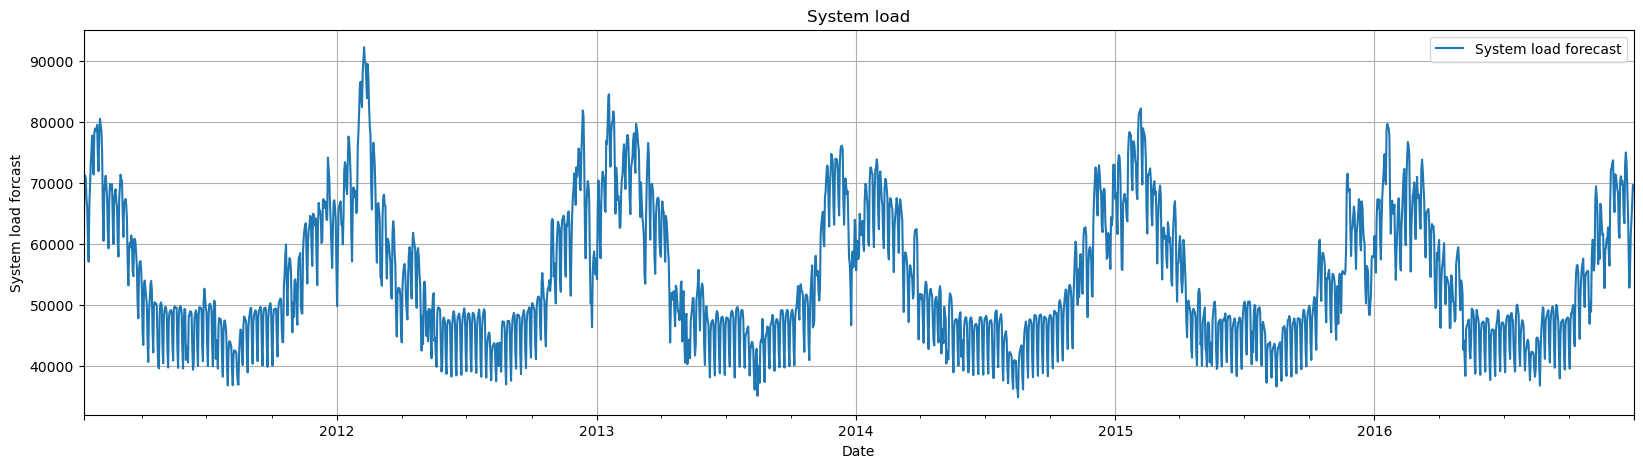

In [12]:
day_load_forecast.plot(kind='line', style='-', figsize=(20,5))
plt.ylabel('System load forcast')
plt.title('System load')
plt.legend()
plt.grid()
plt.show()

The System load forecast makes sense as every year, people usualy tend to use more electricity in winter for heating ...
In the middle of the year, they use air conditioning but it is less electricity consuming than heating.

In [13]:
Data.describe()

,Prices,Generation forecast,System load forecast
count,52416.000000,52416.000000,52416.000000
mean,41.453914,59466.665408,54167.668307
std,23.077340,10454.753566,12080.800317
min,-200.000000,33153.000000,28700.000000
25%,28.979750,51575.000000,45100.000000
50%,41.000000,58107.000000,52479.500000
75%,52.830000,66088.000000,62280.250000
max,1938.500000,93517.000000,99900.000000


In [14]:
Data.resample("D").median()

,Prices,Generation forecast,System load forecast
Date,,,
2011-01-09,41.3315,63236.0,58800.0
2011-01-10,58.7205,72159.5,73400.0
2011-01-11,62.8110,73437.5,71900.0
2011-01-12,57.7830,71739.0,71550.0
2011-01-13,49.9870,69844.5,67350.0
...,...,...,...
2016-12-27,52.9350,61791.0,62406.0
2016-12-28,51.3000,62063.5,64485.5
2016-12-29,53.0750,63904.5,66814.0


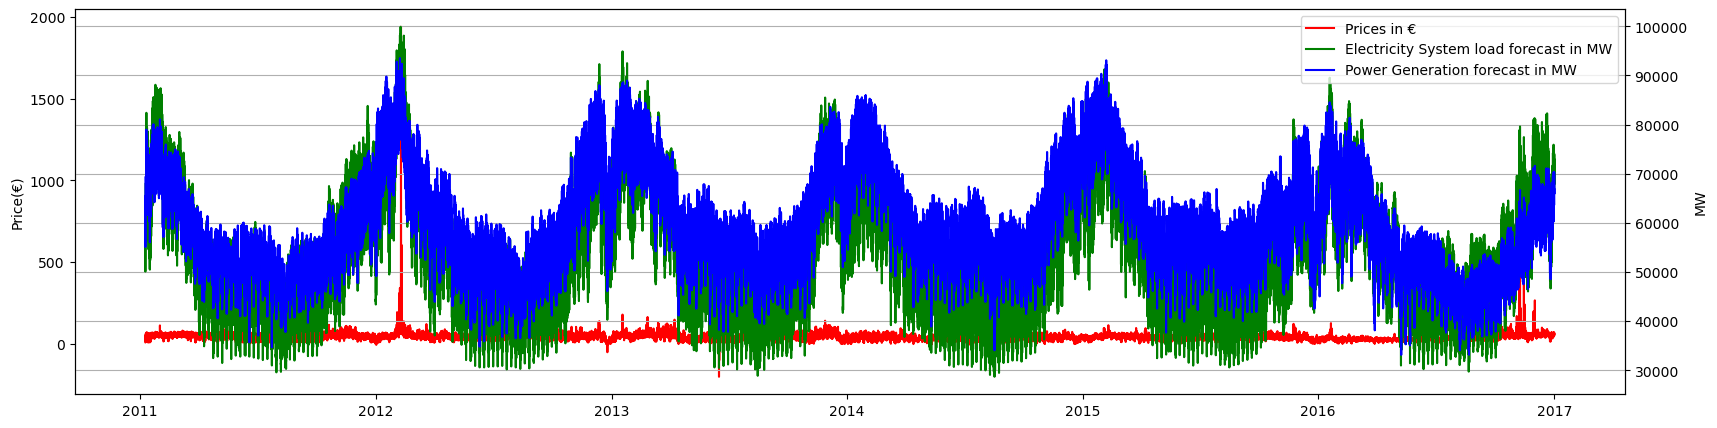

In [15]:
#Displaying all variables on a single plot
fig, ax1=plt.subplots(figsize=(20, 5))

#Plot Prices in red
ax1.plot(Data["Prices"], label="Prices in €", color="red")
ax1.tick_params(axis="y")
plt.ylabel('Price(€)')

ax2= ax1.twinx()
#Plot Electricity System Load Forecast in green
ax2.plot(Data["System load forecast"], label="Electricity System load forecast in MW", color="green")
ax2.tick_params(axis="y")
plt.ylabel('MW')

#Plot Power Genration Forecast in blue
ax2.plot(Data["Generation forecast"], label="Power Generation forecast in MW", color="blue")
ax2.tick_params(axis="y")
plt.ylabel('MW')

#legend
lines1, labels1=ax1.get_legend_handles_labels()
lines2, labels2=ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper right")
plt.grid()
plt.show()

In [16]:
#Correlation
corr=Data.corr()
corr

,Prices,Generation forecast,System load forecast
Prices,1.000000,0.405030,0.489219
Generation forecast,0.405030,1.000000,0.908094
System load forecast,0.489219,0.908094,1.000000


In [17]:
#decomposing the data in time period to analyse the outliers
Data_Date = data.copy(deep=True)

Data_Date['weekday'] = Data_Date['Date'].dt.day_name()
Data_Date['month'] = Data_Date['Date'].dt.month_name()
Data_Date['quarter']=Data_Date["Date"].apply(lambda x: x.quarter)
Data_Date['year'] = Data_Date['Date'].dt.year.astype('string')
Data_Date['hour'] = Data_Date['Date'].dt.strftime('%H').astype('string')
Data_Date.head()

,Date,Prices,Generation forecast,System load forecast,weekday,month,quarter,year,hour
0,2011-01-09 00:00:00,32.542,63065.0,63000.0,Sunday,January,1,2011,00
1,2011-01-09 01:00:00,21.549,62715.0,58800.0,Sunday,January,1,2011,01
2,2011-01-09 02:00:00,15.711,61952.0,58500.0,Sunday,January,1,2011,02
3,2011-01-09 03:00:00,10.583,59262.0,54300.0,Sunday,January,1,2011,03
4,2011-01-09 04:00:00,10.324,56883.0,51900.0,Sunday,January,1,2011,04


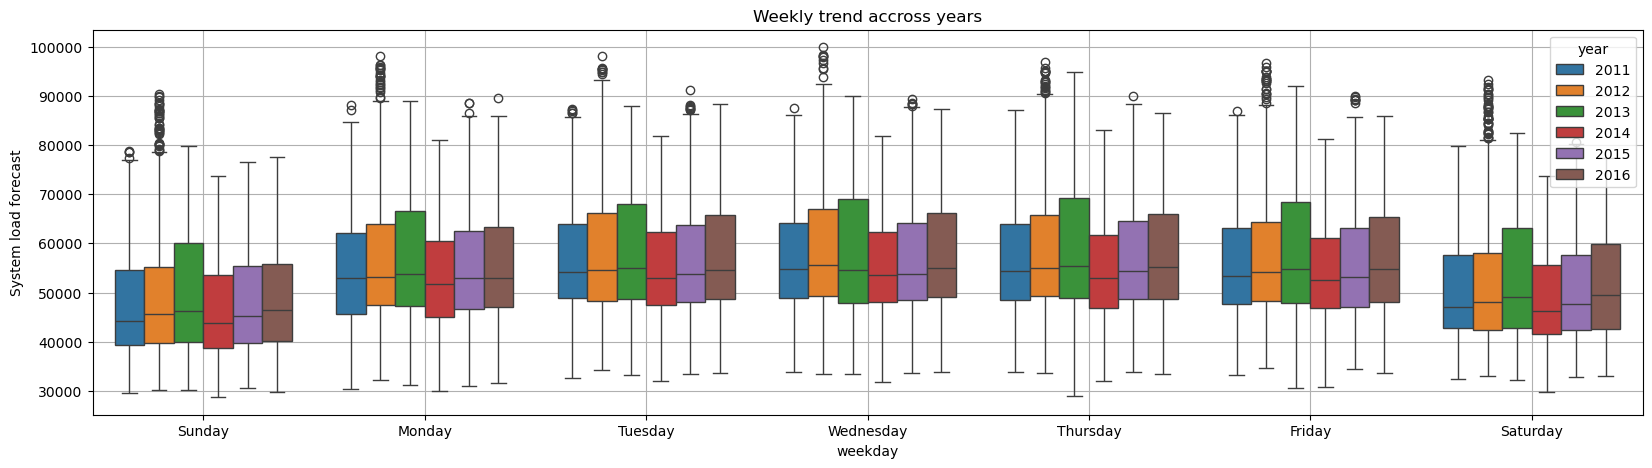

In [18]:
#ploting outliers on system load forecast
fig,axes=plt.subplots(1,1, figsize=(20,5))
sns.boxplot(Data_Date,x='weekday',y='System load forecast',hue='year',palette='tab10',ax=axes)
plt.title('Weekly trend accross years')
plt.grid()
plt.show()

We saw a decline in electricity demand between 2013 and 2014. We'll keep the outliers because they explain the volatility of the energy market. So we'll either try to model them or simply keep them and perform a risk analysis afterward.

In [19]:
#Flagging outliers
data_outliers=Data_Date.copy("deep")
Q3 = data_outliers["System load forecast"].quantile(0.75)
Q1 = data_outliers["System load forecast"].quantile(0.25)
IQR= Q3-Q1
data_outliers["FLAG_OUTLIERS"]=data_outliers["System load forecast"] > (Q3+ 1.5*IQR)

data_outliers["FLAG_OUTLIERS"].sum()

205

In [20]:
data_outliers.head()

,Date,Prices,Generation forecast,System load forecast,weekday,month,quarter,year,hour,FLAG_OUTLIERS
0,2011-01-09 00:00:00,32.542,63065.0,63000.0,Sunday,January,1,2011,00,False
1,2011-01-09 01:00:00,21.549,62715.0,58800.0,Sunday,January,1,2011,01,False
2,2011-01-09 02:00:00,15.711,61952.0,58500.0,Sunday,January,1,2011,02,False
3,2011-01-09 03:00:00,10.583,59262.0,54300.0,Sunday,January,1,2011,03,False
4,2011-01-09 04:00:00,10.324,56883.0,51900.0,Sunday,January,1,2011,04,False


In [21]:
#looking and storing the part of the data without outliers
data_drop_outliers=data_outliers.loc[~data_outliers["FLAG_OUTLIERS"]]
data_drop_outliers.head()

,Date,Prices,Generation forecast,System load forecast,weekday,month,quarter,year,hour,FLAG_OUTLIERS
0,2011-01-09 00:00:00,32.542,63065.0,63000.0,Sunday,January,1,2011,00,False
1,2011-01-09 01:00:00,21.549,62715.0,58800.0,Sunday,January,1,2011,01,False
2,2011-01-09 02:00:00,15.711,61952.0,58500.0,Sunday,January,1,2011,02,False
3,2011-01-09 03:00:00,10.583,59262.0,54300.0,Sunday,January,1,2011,03,False
4,2011-01-09 04:00:00,10.324,56883.0,51900.0,Sunday,January,1,2011,04,False


In [22]:
#Extending the data into the different part of a day in order to track the trends
data_outliers['feat_monthName'] = data_outliers['Date'].dt.month
data_outliers['feat_isNight'] = (data_outliers['Date'].dt.hour>17).astype(int)
data_outliers['feat_isDawn'] = ((data_outliers['Date'].dt.hour<=6) &  (data_outliers['Date'].dt.hour>=0) ).astype(int)
data_outliers['feat_isMorning'] = ((data_outliers['Date'].dt.hour>6) &  (data_outliers['Date'].dt.hour<=12) ).astype(int)
data_outliers['feat_isAfternoon'] = ((data_outliers['Date'].dt.hour>12) &  (data_outliers['Date'].dt.hour<=16) ).astype(int)

data_outliers.head()

,Date,Prices,Generation forecast,System load forecast,weekday,month,quarter,year,hour,FLAG_OUTLIERS,feat_monthName,feat_isNight,feat_isDawn,feat_isMorning,feat_isAfternoon
0,2011-01-09 00:00:00,32.542,63065.0,63000.0,Sunday,January,1,2011,00,False,1,0,1,0,0
1,2011-01-09 01:00:00,21.549,62715.0,58800.0,Sunday,January,1,2011,01,False,1,0,1,0,0
2,2011-01-09 02:00:00,15.711,61952.0,58500.0,Sunday,January,1,2011,02,False,1,0,1,0,0
3,2011-01-09 03:00:00,10.583,59262.0,54300.0,Sunday,January,1,2011,03,False,1,0,1,0,0
4,2011-01-09 04:00:00,10.324,56883.0,51900.0,Sunday,January,1,2011,04,False,1,0,1,0,0


A little bit of **FEATURES ENGINEERING** : The power feature is expanded with six additional features, each containing power values shifted back by 1, 12, 24, 28, 48, and 72 time units respectively.

In [23]:
for x in [1,12,24,48,72]:
    data_outliers[f'lagged_load_{x}'] = data_outliers['System load forecast'].shift(x).bfill()

#build some rolling features like rolling mean 
data_outliers['rolling_4_load_mean'] = data_outliers['System load forecast'].rolling(4, 1).mean().shift().bfill()
data_outliers['rolling_24_load_mean'] = data_outliers['System load forecast'].rolling(24, 1).mean().shift().bfill()

print(f'features are :{data_outliers.columns}')

features are :Index(['Date', 'Prices', 'Generation forecast', 'System load forecast',
       'weekday', 'month', 'quarter', 'year', 'hour', 'FLAG_OUTLIERS',
       'feat_monthName', 'feat_isNight', 'feat_isDawn', 'feat_isMorning',
       'feat_isAfternoon', 'lagged_load_1', 'lagged_load_12', 'lagged_load_24',
       'lagged_load_48', 'lagged_load_72', 'rolling_4_load_mean',
       'rolling_24_load_mean'],
      dtype='object')


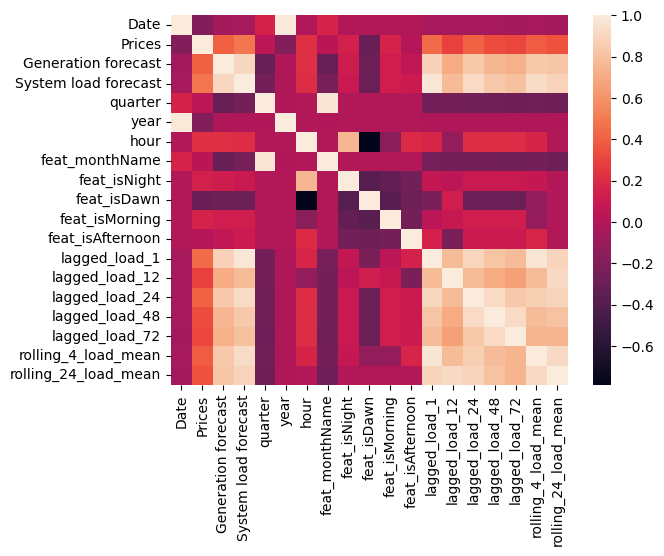

In [24]:
sns.heatmap(data_outliers.drop(["FLAG_OUTLIERS","weekday","month"], axis=1).corr())
plt.show()

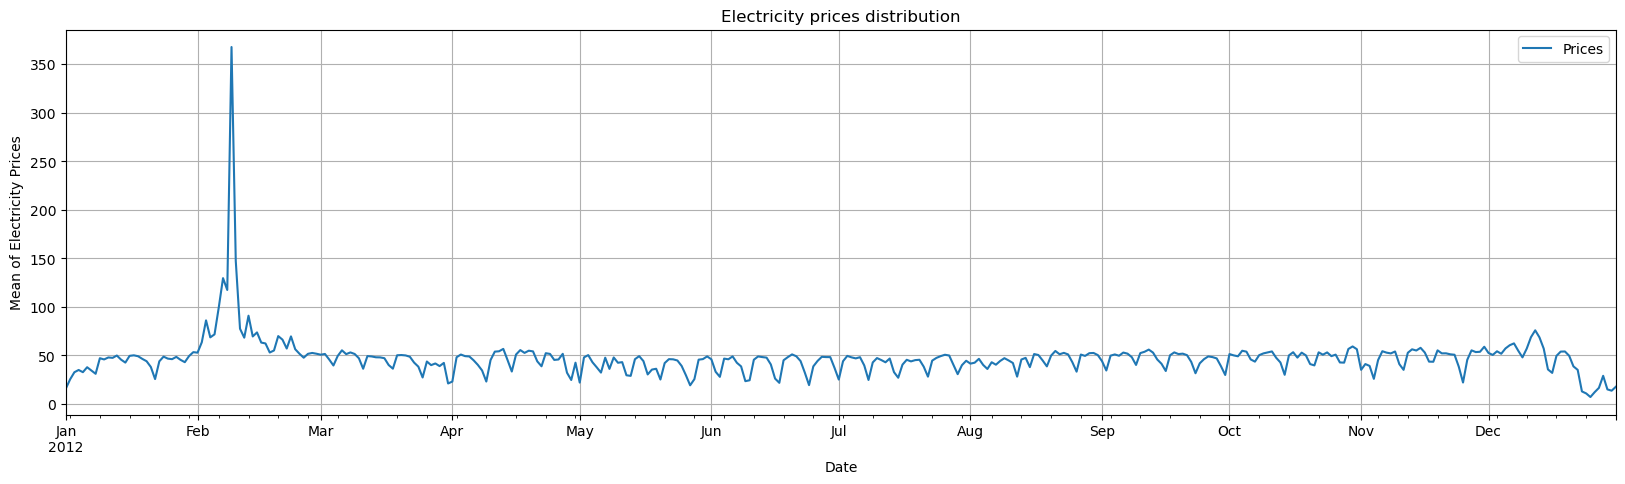

In [25]:
#price distribution
Price=Data["Prices"].resample('D').mean()
Price["2012"].plot(kind='line', style='-', figsize=(20,5))
plt.ylabel('Mean of Electricity Prices')
plt.title('Electricity prices distribution')
plt.legend()
plt.grid()
plt.show()

The electricity price is overall stable, except the electricity price in the first quarter if 2012 which might be an outlier or a representation of a critical period.

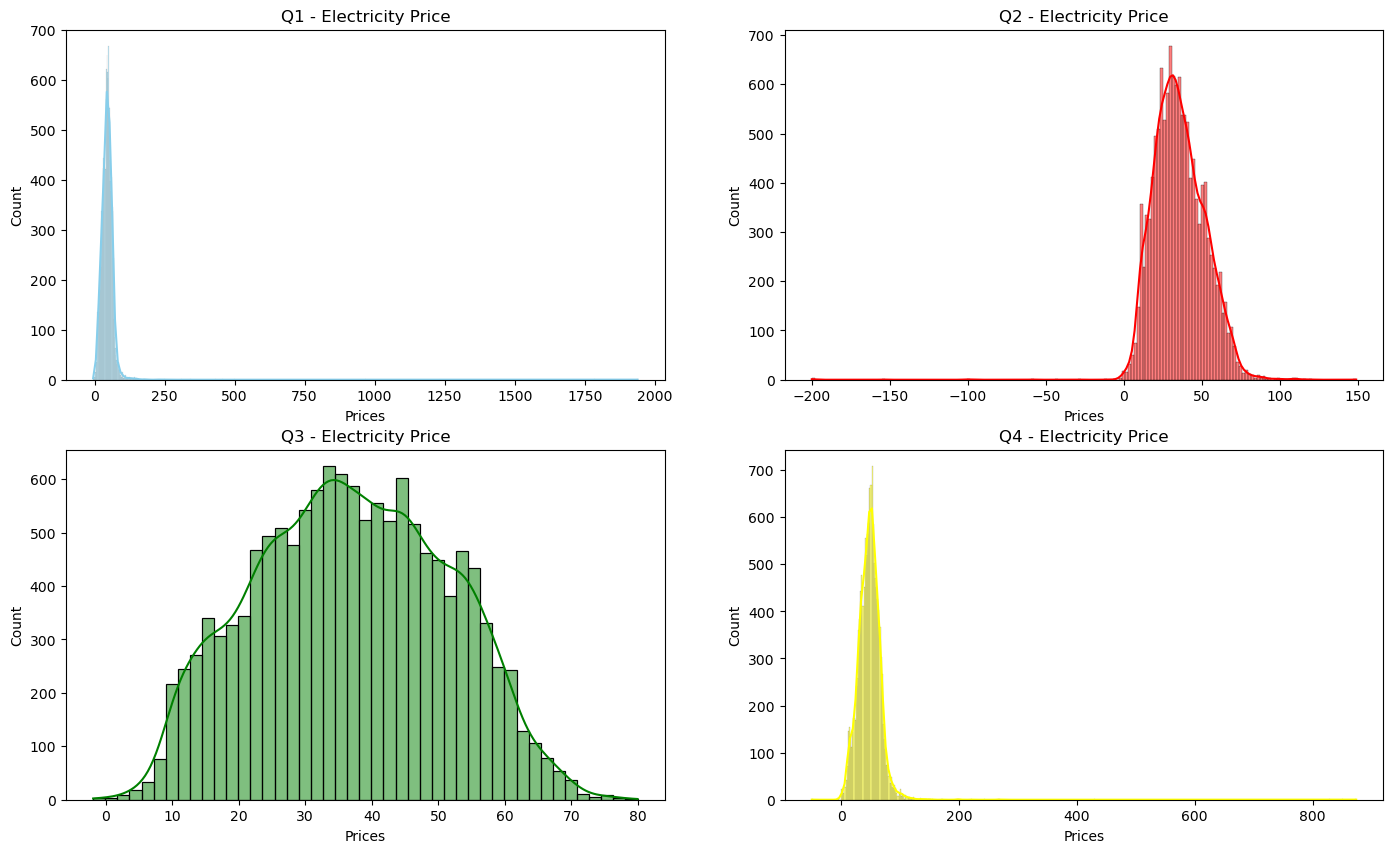

In [26]:
#Let's see the distribution of the electricity price per quarter
Q1=Data_Date[Data_Date["quarter"]==1]
Q2=Data_Date[Data_Date["quarter"]==2]
Q3=Data_Date[Data_Date["quarter"]==3]
Q4=Data_Date[Data_Date["quarter"]==4]

#Plot
fig,axes = plt.subplots(2,2,figsize=(17,10),sharex=False,sharey=False)

sns.histplot(Q1["Prices"],color="skyblue", ax=axes[0,0], kde=True).set_title("Q1 - Electricity Price")
sns.histplot(Q2["Prices"],color="red", ax=axes[0,1], kde=True).set_title("Q2 - Electricity Price")
sns.histplot(Q3["Prices"],color="green", ax=axes[1,0], kde=True).set_title("Q3 - Electricity Price")
sns.histplot(Q4["Prices"],color="yellow",ax=axes[1,1], kde=True).set_title("Q4 - Electricity Price")

plt.show()

In [27]:
#to play a little bit, let test the normality with H0 test
stat, p =stats.normaltest(Data_Date["Prices"])

print('Statistics=%.3f, p=%.3f' % (stat, p))

#set significance level
alpha = 0.05

#Result on normality
if p> alpha :
    print("Data_Date looks Gaussian (fail to reject H0)")
else:
    print("Data_Date doesn't look Gaussian (reject H0)")

Statistics=127461.542, p=0.000
Data_Date doesn't look Gaussian (reject H0)


Kurtosis of distribution: 1702.5943625386653
Skewness of distribution: 24.967176191185114


<Figure size 2000x800 with 0 Axes>

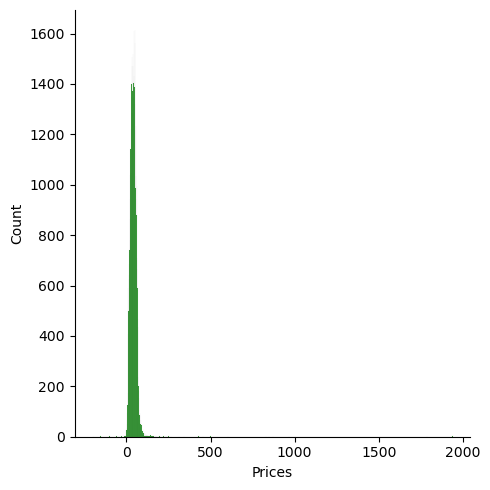

max prices is 1938.5 and min is -200.0


In [28]:
plt.figure(figsize=(20,8))
sns.displot(Data_Date["Prices"], color='green')
print("Kurtosis of distribution: {}".format(stats.kurtosis(Data_Date["Prices"])))
print("Skewness of distribution: {}".format(stats.skew(Data_Date["Prices"])))
plt.show()
print(f"max prices is {Data_Date["Prices"].max()} and min is {Data_Date["Prices"].min()}")

C:\Users\setha\AppData\Local\Temp\ipykernel_31200\3027744556.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


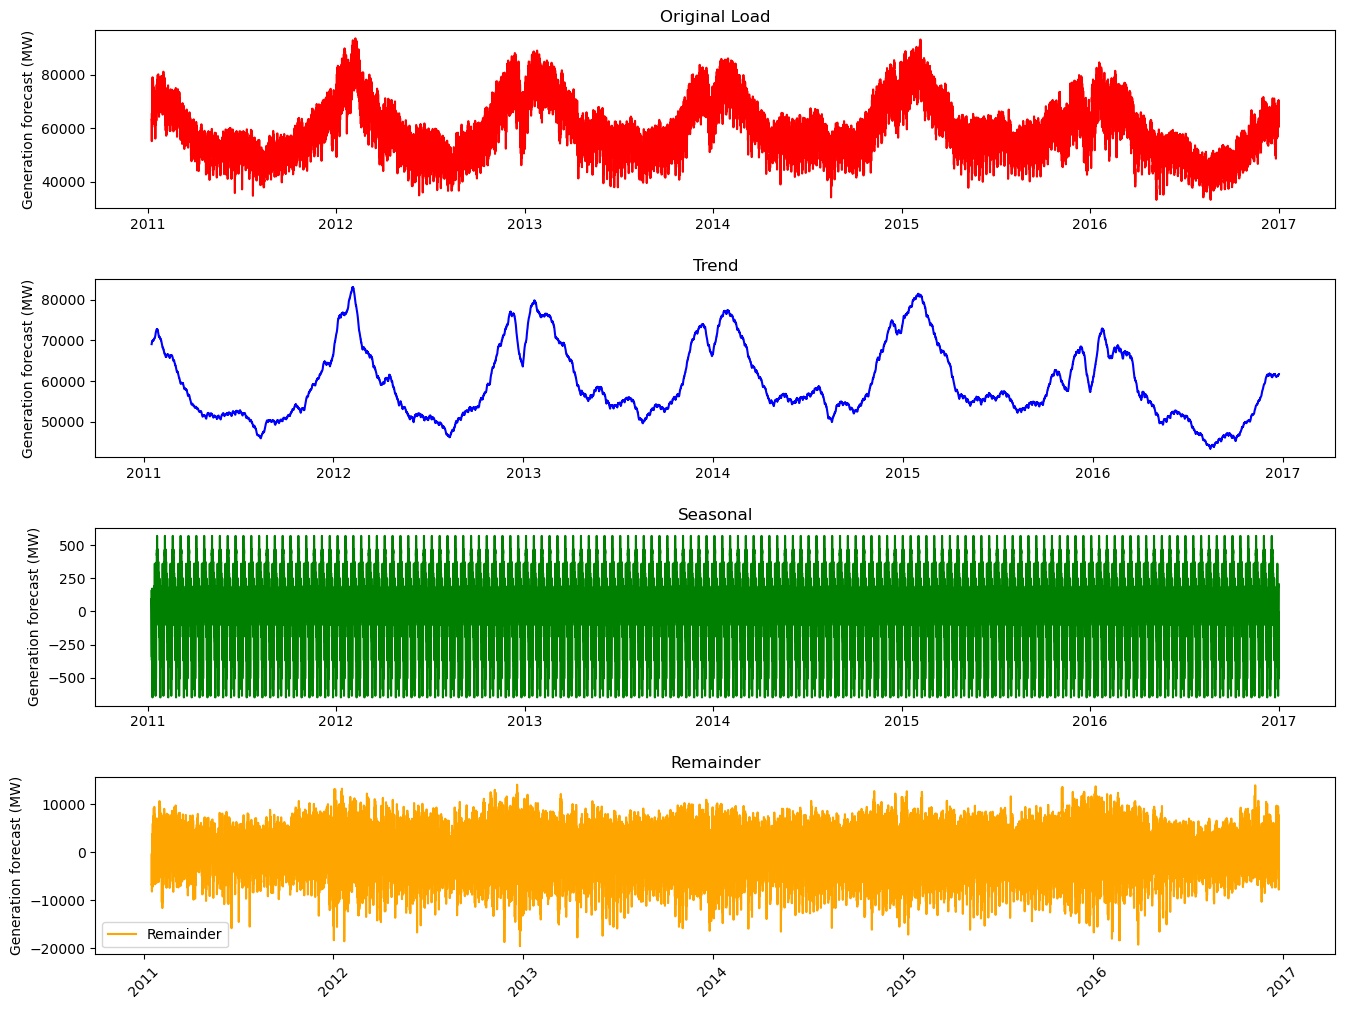

In [29]:
df2 = Data[['Generation forecast']] 

#Decompose the data
decomposition = seasonal_decompose(df2, period=365)

#Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
remainder = decomposition.resid
original = df2['Generation forecast'] 

#Create a figure with 4 subplots (original on top, others stacked below)
fig, axes = plt.subplots(4, 1, figsize=(16, 12), gridspec_kw={'hspace': 0.4})  #Adjust figsize as needed

#Plot original on top subplot
axes[0].plot(original, color='red', label='Original Load')
axes[0].set(ylabel='Generation forecast (MW)', title='Original Load')

#Plot remaining components on stacked subplots
axes[1].plot(trend, color='blue', label='Trend')
axes[1].set(ylabel='Generation forecast (MW)', title='Trend')
axes[2].plot(seasonal, color='green', label='Seasonal')
axes[2].set(ylabel='Generation forecast (MW)', title='Seasonal')
axes[3].plot(remainder, color='orange', label='Remainder')
axes[3].set(ylabel='Generation forecast (MW)', title='Remainder')

#legend
axes[3].legend() 

plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

Times series test

As we are looking to apply the LSTM, we're trying to see the stationarity of the data through of Dickey-Fuller test. 
Dickey-Fuller test is a statistical test to determine the stationarity of a time series¶
The Dickey-Fuller test is used to test the null hypothesis that a unit root is present in a time series, which means it is non-stationary and has some time-dependent structure. On the other hand, the alternative hypothesis is that the time series does not have a unit root, meaning it is stationary and does not have time-dependent structure.

In the Dickey-Fuller test, if the p-value is greater than 0.05, it means we accept the null hypothesis and the data is considered to be non-stationary. However, if the p-value is less than or equal to 0.05, we reject the null hypothesis and the data is considered to be stationary.

While LSTM models do not require stationarity of the data, a stationary series with constant mean and variance over time can result in better performance and make it easier for the neural network to learn.

In [30]:
def test_stationarity(timeseries):
    #Calculate rolling mean and standard deviation
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    #Plot original timeseries, rolling mean, and rolling standard deviation
    plt.figure(figsize=(20,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='purple',label='Original')
    mean = plt.plot(rolmean, color='yellow', label='Rolling Mean')
    std = plt.plot(rolstd, color='cyan', label = 'Rolling Std')

    #legend and title
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation of Cost(€/MWh)')
    plt.show()

    #Perform and display results of Dickey-Fuller test
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                     index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

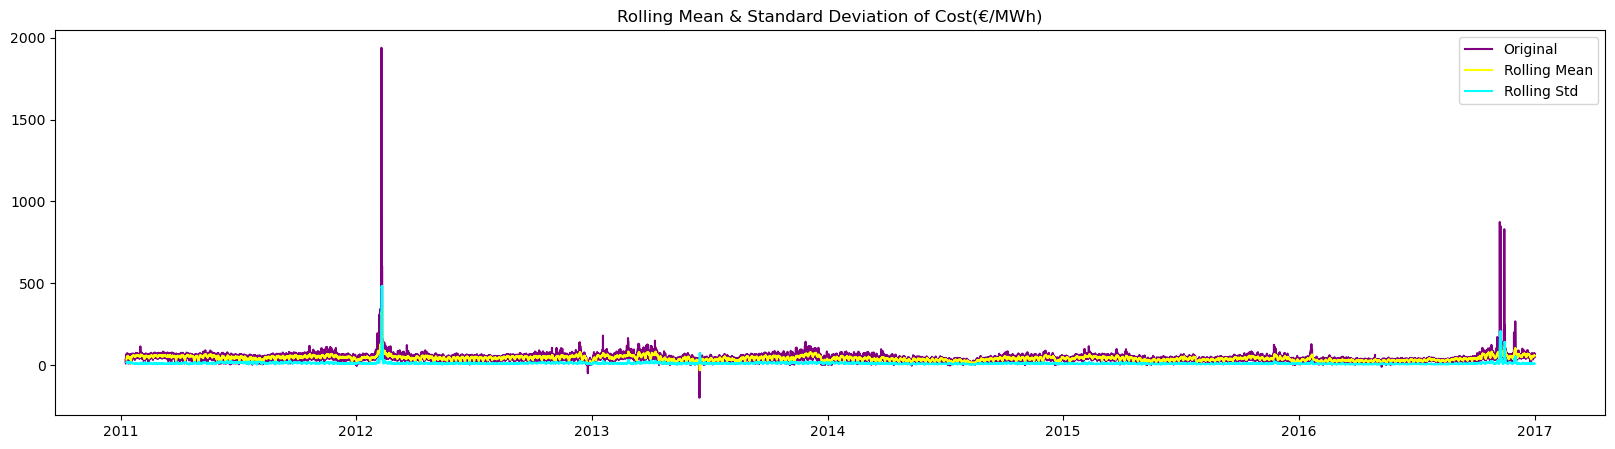

<Results of Dickey-Fuller Test>
Test Statistic                -1.559710e+01
p-value                        1.848956e-28
#Lags Used                     5.800000e+01
Number of Observations Used    5.235700e+04
Critical Value (1%)           -3.430475e+00
Critical Value (5%)           -2.861595e+00
Critical Value (10%)          -2.566799e+00
dtype: float64


In [31]:
test_stationarity(Data["Prices"])

The null hypothesis, which suggests the presence of a unit root and therefore non-stationarity in the time series, can be rejected based on the results of the Dickey-Fuller test.

This implies that the data does not have a time-dependent structure and is stationary.

Thus to accomplish our goal to predict electricity prices, we will use a multi-layer LSTM recurrent neural network. To ensure that the model provides an accurate prediction, the data will be kept at its original minute-level resolution, instead of being resampled to a lower frequency such as hours.

Modelling and Evaluation

    Modelling

In [32]:
data_outliers.columns

Index(['Date', 'Prices', 'Generation forecast', 'System load forecast',
       'weekday', 'month', 'quarter', 'year', 'hour', 'FLAG_OUTLIERS',
       'feat_monthName', 'feat_isNight', 'feat_isDawn', 'feat_isMorning',
       'feat_isAfternoon', 'lagged_load_1', 'lagged_load_12', 'lagged_load_24',
       'lagged_load_48', 'lagged_load_72', 'rolling_4_load_mean',
       'rolling_24_load_mean'],
      dtype='object')

In [33]:
#Defining the timestep for the prediction
target_ahead_timeblocks = 8  # 2hours ahead

data_outliers['target'] = data_outliers['Prices'].shift(-target_ahead_timeblocks)

#Features definition (removing 'Date')
features = ['Prices', 'System load forecast', 'Generation forecast', 
            'feat_monthName', 'feat_isNight', 'feat_isDawn',
            'feat_isMorning', 'feat_isAfternoon', 'lagged_load_1',
            'lagged_load_12', 'lagged_load_24', 'lagged_load_48',
            'lagged_load_72', 'rolling_4_load_mean', 'rolling_24_load_mean']

train_data = data_outliers[features + ['target']].copy()

#Removing NaN values created by .shift()
train_data = train_data.dropna()
print(train_data.shape)
train_data.head()

(52408, 16)


,Prices,System load forecast,Generation forecast,feat_monthName,feat_isNight,feat_isDawn,feat_isMorning,feat_isAfternoon,lagged_load_1,lagged_load_12,lagged_load_24,lagged_load_48,lagged_load_72,rolling_4_load_mean,rolling_24_load_mean,target
0,32.542,63000.0,63065.0,1,0,1,0,0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,10.191
1,21.549,58800.0,62715.0,1,0,1,0,0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,30.000
2,15.711,58500.0,61952.0,1,0,1,0,0,58800.0,63000.0,63000.0,63000.0,63000.0,60900.0,60900.0,46.022
3,10.583,54300.0,59262.0,1,0,1,0,0,58500.0,63000.0,63000.0,63000.0,63000.0,60100.0,60100.0,50.835
4,10.324,51900.0,56883.0,1,0,1,0,0,54300.0,63000.0,63000.0,63000.0,63000.0,58650.0,58650.0,53.024


In [34]:
#X and target
X = train_data[features].copy()
y = train_data[['target']].copy()

In [35]:
#Definig cut-off date for validation and test
valid_cutoff_date = '2015-01-01 00:00:00'
test_cutoff_date = '2015-06-01 00:00:00'

#Addind 'Date' for the split
X['Date'] = data_outliers['Date'] 
y['Date'] = data_outliers['Date']

In [36]:
#Splitting the data into 3 mains part : train, validation and test
x_train = X[X['Date'] < valid_cutoff_date].drop(columns=['Date']).copy()
y_train = y[y['Date'] < valid_cutoff_date].drop(columns=['Date']).copy()
x_val = X[(X['Date'] >= valid_cutoff_date) & (X['Date'] < test_cutoff_date)].drop(columns=['Date']).copy()
y_val = y[(y['Date'] >= valid_cutoff_date) & (y['Date'] < test_cutoff_date)].drop(columns=['Date']).copy()
x_test = X[X['Date'] >= test_cutoff_date].drop(columns=['Date']).copy()
y_test = y[y['Date'] >= test_cutoff_date].drop(columns=['Date']).copy()

# Reshape for LSTM (samples, timesteps, features)
timesteps = 1  
x_train = x_train.values.reshape((x_train.shape[0], timesteps, x_train.shape[1]))
x_val = x_val.values.reshape((x_val.shape[0], timesteps, x_val.shape[1]))
x_test = x_test.values.reshape((x_test.shape[0], timesteps, x_test.shape[1]))

BI-LSTM Model: 1

In [37]:
#Setting up the Bidriectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(100, return_sequences=False), input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

#Compilation
model.compile(loss='mean_squared_error', optimizer='adam')

#Training with EarlyStopping
history = model.fit(
    x_train, y_train, 
    epochs=20, 
    batch_size=1240, 
    validation_data=(x_val, y_val), 
    callbacks=[EarlyStopping(monitor='val_loss', patience=4)], 
    verbose=1, 
    shuffle=False
)

model.summary()

c:\Users\setha\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 2873.9243 - val_loss: 1626.6173
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2696.9321 - val_loss: 1554.9924
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2614.0740 - val_loss: 1488.0767
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2533.8621 - val_loss: 1424.1541
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2457.5327 - val_loss: 1362.8373
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2383.3745 - val_loss: 1303.9567
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2312.0386 - val_loss: 1247.4058
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2244.3589 - val_loss: 1193.0861
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2177.8066 - val_loss: 1140.8779
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2113.5281 - val_loss: 1090.7365
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2051.9426 - val_loss: 1042.60

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 200)            │        92,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 279,005 (1.06 MB)

 Trainable params: 93,001 (363.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 186,004 (726.58 KB)

    Evaluation

In [38]:
#Reshape data for robustScaler (into 2D)
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)  
x_test_reshaped = x_test.reshape(x_test.shape[0], -1)  

#initialisation of the scaler for x_train
x_scaler = RobustScaler()
x_scaler.fit(x_train_reshaped)

#Data transformation
scaled_x_train = x_scaler.transform(x_train_reshaped)
scaled_x_test = x_scaler.transform(x_test_reshaped)

#back to 3D for Bi-LSTM
scaled_x_train = scaled_x_train.reshape(x_train.shape)
scaled_x_test = scaled_x_test.reshape(x_test.shape)

#Initialisation of scaler for y_train
scaler_y = RobustScaler()

#Reshape y_train into 2D
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

#Transforming y_test with parameters learned from y_train
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

#Predictions
train_predict = model.predict(scaled_x_train)
test_predict = model.predict(scaled_x_test)

#Inversing prediction and true values
train_predict_inv = scaler_y.inverse_transform(train_predict.reshape(-1,1))
test_predict_inv = scaler_y.inverse_transform(test_predict.reshape(-1,1))
                                              
y_train_inv = scaler_y.inverse_transform(y_train_scaled)
y_test_inv = scaler_y.inverse_transform(y_test_scaled)

#Errors metrics
print('Train Mean Absolute Error:', mean_absolute_error(y_train_inv, train_predict_inv))
print('Train Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train_inv, train_predict_inv)))
print('Test Mean Absolute Error:', mean_absolute_error(y_test_inv, test_predict_inv))
print('Test Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test_inv, test_predict_inv)))


1090/1090 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
Train Mean Absolute Error: 22.99743042733774
Train Root Mean Squared Error: 31.37802703564475
Test Mean Absolute Error: 25.619932694152695
Test Root Mean Squared Error: 31.925386216602423


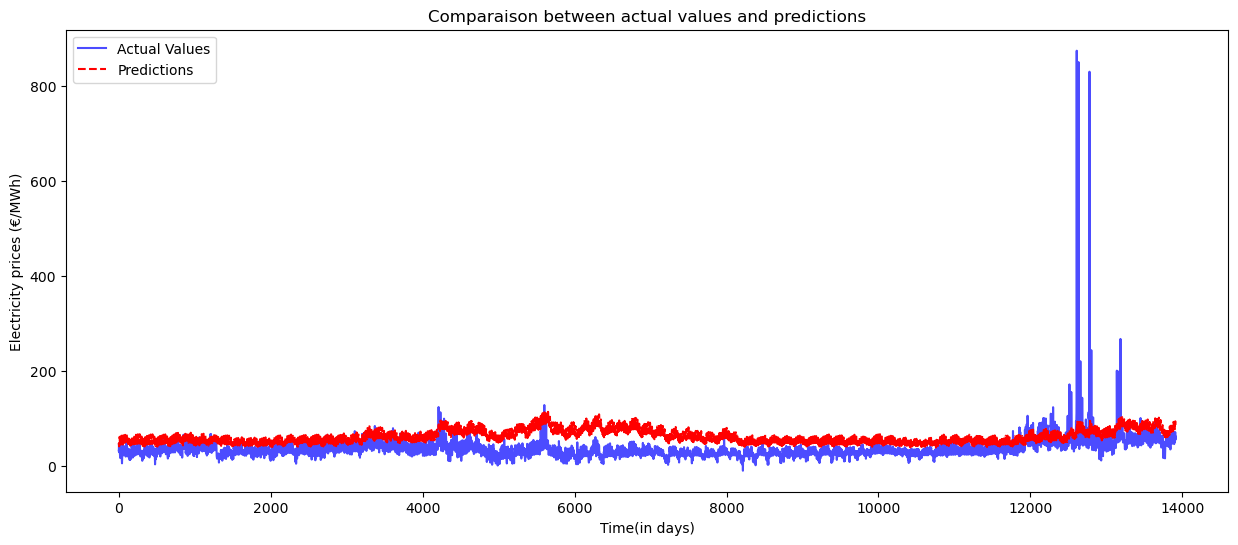

In [39]:
#Plotting actual values and predictions
plt.figure(figsize=(15,6))
plt.plot(y_test_inv, label="Actual Values", color='blue', alpha=0.7)
plt.plot(test_predict_inv, label="Predictions", color='red', linestyle="dashed")
plt.title("Comparaison between actual values and predictions")
plt.xlabel("Time(in days)")
plt.ylabel("Electricity prices (€/MWh)")
plt.legend()
plt.show()


RANDOM FOREST

    Modelling

In [40]:
data_outliers.columns

Index(['Date', 'Prices', 'Generation forecast', 'System load forecast',
       'weekday', 'month', 'quarter', 'year', 'hour', 'FLAG_OUTLIERS',
       'feat_monthName', 'feat_isNight', 'feat_isDawn', 'feat_isMorning',
       'feat_isAfternoon', 'lagged_load_1', 'lagged_load_12', 'lagged_load_24',
       'lagged_load_48', 'lagged_load_72', 'rolling_4_load_mean',
       'rolling_24_load_mean', 'target'],
      dtype='object')

In [41]:
df1=data_outliers.loc[~data_outliers["FLAG_OUTLIERS"]] 
df1.head()

,Date,Prices,Generation forecast,System load forecast,weekday,month,quarter,year,hour,FLAG_OUTLIERS,...,feat_isMorning,feat_isAfternoon,lagged_load_1,lagged_load_12,lagged_load_24,lagged_load_48,lagged_load_72,rolling_4_load_mean,rolling_24_load_mean,target
0,2011-01-09 00:00:00,32.542,63065.0,63000.0,Sunday,January,1,2011,00,False,...,0,0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,10.191
1,2011-01-09 01:00:00,21.549,62715.0,58800.0,Sunday,January,1,2011,01,False,...,0,0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,30.000
2,2011-01-09 02:00:00,15.711,61952.0,58500.0,Sunday,January,1,2011,02,False,...,0,0,58800.0,63000.0,63000.0,63000.0,63000.0,60900.0,60900.0,46.022
3,2011-01-09 03:00:00,10.583,59262.0,54300.0,Sunday,January,1,2011,03,False,...,0,0,58500.0,63000.0,63000.0,63000.0,63000.0,60100.0,60100.0,50.835
4,2011-01-09 04:00:00,10.324,56883.0,51900.0,Sunday,January,1,2011,04,False,...,0,0,54300.0,63000.0,63000.0,63000.0,63000.0,58650.0,58650.0,53.024


In [42]:
#Date into datetime
df1['Date'] = pd.to_datetime(df1['Date'])

df1 = df1.sort_values(by='Date')

C=df1.drop(["Prices", "Date", "weekday", "month", "FLAG_OUTLIERS","target"], axis=1)
d=df1["Prices"]

C:\Users\setha\AppData\Local\Temp\ipykernel_31200\2913318682.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date'] = pd.to_datetime(df1['Date'])


In [43]:
C_train, C_test, d_train, d_test = train_test_split(C, d, test_size=0.2, random_state=42, shuffle=False)

#Scaling features
scaler = RobustScaler()
C_train_scaled = scaler.fit_transform(C_train)
C_test_scaled = scaler.transform(C_test)

#Training
rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)
rf_model.fit(C_train_scaled, d_train)

#Predictions
train_pred = rf_model.predict(C_train_scaled)
test_pred = rf_model.predict(C_test_scaled)

#Errors metrics
train_mae = mean_absolute_error(d_train, train_pred)
train_rmse = np.sqrt(mean_squared_error(d_train, train_pred))
test_mae = mean_absolute_error(d_test, test_pred)
test_rmse = np.sqrt(mean_squared_error(d_test, test_pred))

print(f"Train MAE: {train_mae}")
print(f"Train RMSE: {train_rmse}")
print(f"Test MAE: {test_mae}")
print(f"Test RMSE: {test_rmse}")

Train MAE: 2.7030305578455307
Train RMSE: 3.6766971810964515
Test MAE: 10.384680664370936
Test RMSE: 19.939361851212364


In [44]:
#features importances
features = ['Generation forecast', 'System load forecast',
        'quarter', 'year', 'hour', 
       'feat_monthName', 'feat_isNight', 'feat_isDawn', 'feat_isMorning',
       'feat_isAfternoon', 'lagged_load_1', 'lagged_load_12', 'lagged_load_24',
       'lagged_load_48', 'lagged_load_72', 'rolling_4_load_mean',
       'rolling_24_load_mean']
importances = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)
print("\n Importance des features:\n", importances)


 Importance des features:
 System load forecast    0.475758
year                    0.113576
feat_monthName          0.101200
hour                    0.069346
Generation forecast     0.060015
rolling_24_load_mean    0.031412
lagged_load_72          0.025225
rolling_4_load_mean     0.022909
lagged_load_48          0.020702
lagged_load_12          0.017247
lagged_load_1           0.015924
lagged_load_24          0.014655
feat_isDawn             0.014180
feat_isAfternoon        0.007060
quarter                 0.006960
feat_isMorning          0.002630
feat_isNight            0.001199
dtype: float64


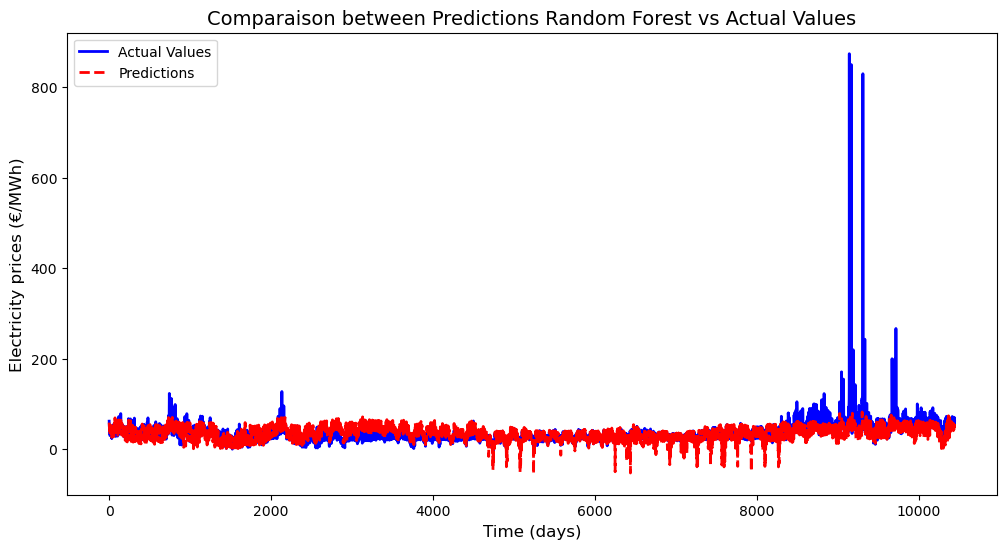

In [45]:
#plotting the results
plt.figure(figsize=(12, 6))
plt.plot(d_test.values, label="Actual Values", color='blue', linewidth=2)
plt.plot(test_pred, label="Predictions", color='red', linestyle='dashed', linewidth=2)
plt.title("Comparaison between Predictions Random Forest vs Actual Values", fontsize=14)
plt.xlabel("Time (days)", fontsize=12)
plt.ylabel("Electricity prices (€/MWh)", fontsize=12)
plt.legend()
plt.show()

RISQUE MESUREMENT

Var estimation using Monte Carlo Simulation

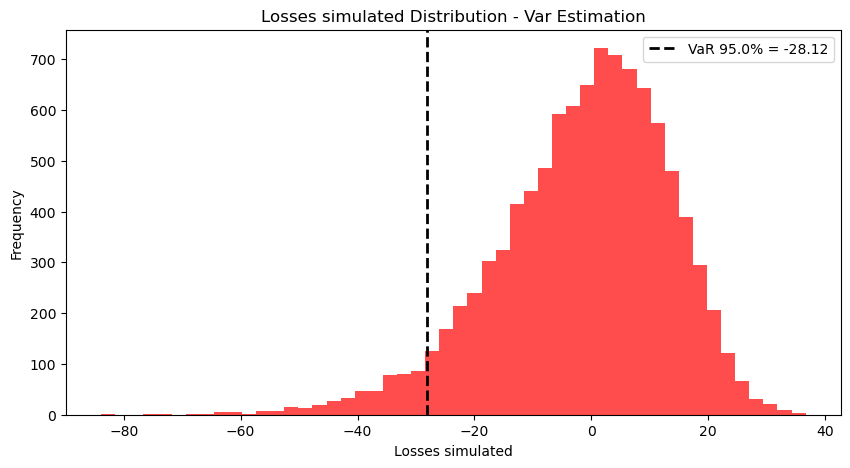

 The Monte Carlo VaR with (95.0% confidence level) is : -28.12


In [47]:
#Parameters
n_simulations = 10000  
confidence_level = 0.95 

#Manage positives and non null values 
epsilon = 1e-6  #low value to avoid log(0)
y_test_inv = np.where(y_test_inv > 0, y_test_inv, epsilon)

#Returns calculation
returns = np.log(y_test_inv[1:] / y_test_inv[:-1])

#Removing NaN values ou infinie values
returns = returns[np.isfinite(returns)] 

if len(returns) == 0:
    raise ValueError("All yield values ​​are NaN or infinite after filtering.")

#mean and volatility estimation
mu = np.mean(returns)
sigma = np.std(returns)

#Monte Carlo simulations of future returns
simulated_returns = np.random.normal(mu, sigma, n_simulations)

#Simulation of future prices senarios
last_price = y_test_inv[-1]
simulated_prices = last_price * np.exp(simulated_returns)

# Loss computation and var estimation
losses = last_price - simulated_prices
VaR = np.percentile(losses, (1 - confidence_level) * 100)

#Plotting losses' distribution
plt.figure(figsize=(10,5))
plt.hist(losses, bins=50, color="red", alpha=0.7)
plt.axvline(VaR, color='black', linestyle='dashed', linewidth=2, label=f'VaR {confidence_level*100}% = {VaR:.2f}')
plt.xlabel("Losses simulated")
plt.ylabel("Frequency")
plt.title("Losses simulated Distribution - Var Estimation")
plt.legend()
plt.show()

print(f" The Monte Carlo VaR with ({confidence_level*100}% confidence level) is : {VaR:.2f}")
